## 1. Import Libraries

Import required libraries for data handling, graph operations, clustering, and visualization.

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from collections import Counter
# Ignore warnings
warnings.filterwarnings("ignore")

## 2. Load the Data

Define a function to load nodes and edges from CSV files and return as dictionaries.

In [ ]:
def load_data():
  
    # Load nodes (Actors data)
    nodes_df = pd.read_csv("Actors_Dataset.csv") 
    nodes = {
        row["id"]: {"name": row["name"], "CGPA": row["CGPA"], "hub": row["hub"], "hometown": row["hometown"]}
        for _, row in nodes_df.iterrows()
    }

    # Load edges (Edges data)
    edges_df = pd.read_csv("Edges_Dataset.csv") 
    layers = {}
    for layer, group in edges_df.groupby("Layer"):
        layers[layer] = list(zip(group["Node 1"], group["Node 2"]))

    return nodes, layers

## 3. Create the Graph

Define a function to build a graph with interlayer connections using nodes and edges data.

In [ ]:
def create_interlayer_graph(nodes, layers):
 
    G = nx.Graph()
    
    # Add nodes with attributes
    for node_id, attrs in nodes.items():
        G.add_node(node_id, **attrs)
    
    # Add edges from each layer
    for layer_name, edges in layers.items():
        for u, v in edges:
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=1.0, layer=layer_name)
            else:
                G[u][v]['weight'] += 1.0
    
    return G

## 4. Perform Spectral Clustering

Perform Spectral Clustering on the graph and return community assignments.

In [ ]:
def spectral_clustering(G, num_clusters=3):
    
    # Extract adjacency matrix
    adjacency_matrix = nx.to_numpy_array(G)
    
    # Apply Spectral Clustering
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(adjacency_matrix)
    
    # Assign clusters as node attributes
    partition = {node: cluster for node, cluster in zip(G.nodes(), labels)}
    
    return partition

## 5. Visualise Communities

Plot the graph with nodes colored based on their community assignments.

In [ ]:
def plot_communities(G, partition, title="Spectral Clustering Results"):
    
    plt.figure(figsize=(16, 12))
    
    # Prepare node colors based on communities
    colors = plt.cm.rainbow(np.linspace(0, 1, len(set(partition.values()))))
    node_colors = [colors[partition[node]] for node in G.nodes()]
    
    # Draw the graph
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos, 
            node_color=node_colors, 
            with_labels=False, 
            node_size=300, 
            alpha=0.6)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

## 6. Plot Adjacency Heatmap

Display the adjacency matrix as a heatmap to analyze connections.

In [ ]:
def adjacency_heatmap(G):
    
    adjacency_matrix = nx.to_numpy_array(G)
    plt.figure(figsize=(10, 8))
    sns.heatmap(adjacency_matrix, cmap='viridis', cbar=True)
    plt.title("Adjacency Matrix Heatmap")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    plt.tight_layout()
    plt.show()

## 7. Silhouette Score Visualization

Calculate and visualize the silhouette score for clustering.

In [ ]:
def plot_silhouette(G, partition):
   
    adjacency_matrix = nx.to_numpy_array(G)
    labels = np.array(list(partition.values()))
    
    # Compute Silhouette Score
    score = silhouette_score(adjacency_matrix, labels, metric="precomputed")
    
    # Plot the score
    plt.figure(figsize=(8, 6))
    plt.bar(["Silhouette Score"], [score], color="skyblue")
    plt.title(f"Silhouette Score: {score:.2f}")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.show()

## 8. Community Composition Heatmap

Visualize the composition of communities based on a chosen attribute.

In [ ]:
def community_composition_heatmap(partition, nodes, attribute, top_n=5):
    
    # Count the number of nodes in each community
    community_sizes = Counter(partition.values())
    
    # Get the top N communities by size
    top_communities = community_sizes.most_common(top_n)
    top_community_ids = [community_id for community_id, _ in top_communities]
    
    # Filter the partition and nodes for top communities
    filtered_partition = {node: community for node, community in partition.items() if community in top_community_ids}
    filtered_nodes = {node: nodes[node] for node in filtered_partition if node in nodes}
    
    # Create a DataFrame for the heatmap
    composition_data = pd.DataFrame(0, 
                                    index=[f"Community {c}" for c in top_community_ids], 
                                    columns=pd.unique([node_data["hometown"] for node_data in filtered_nodes.values()]))

    # Fill composition data
    for node, community in filtered_partition.items():
        hometown = filtered_nodes[node]["hometown"]
        composition_data.loc[f"Community {community}", hometown] += 1

    # Normalize rows for better visualization
    composition_data = composition_data.div(composition_data.sum(axis=1), axis=0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(composition_data, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, xticklabels=True, yticklabels=True)
    plt.title(f"Community Composition by {attribute.capitalize()} (Top {top_n} Communities)")
    plt.ylabel(attribute.capitalize())
    plt.xlabel("Communities")
    plt.tight_layout()
    plt.show()

## 9. Main Workflow

Load data, create the graph, perform clustering, and visualize results.

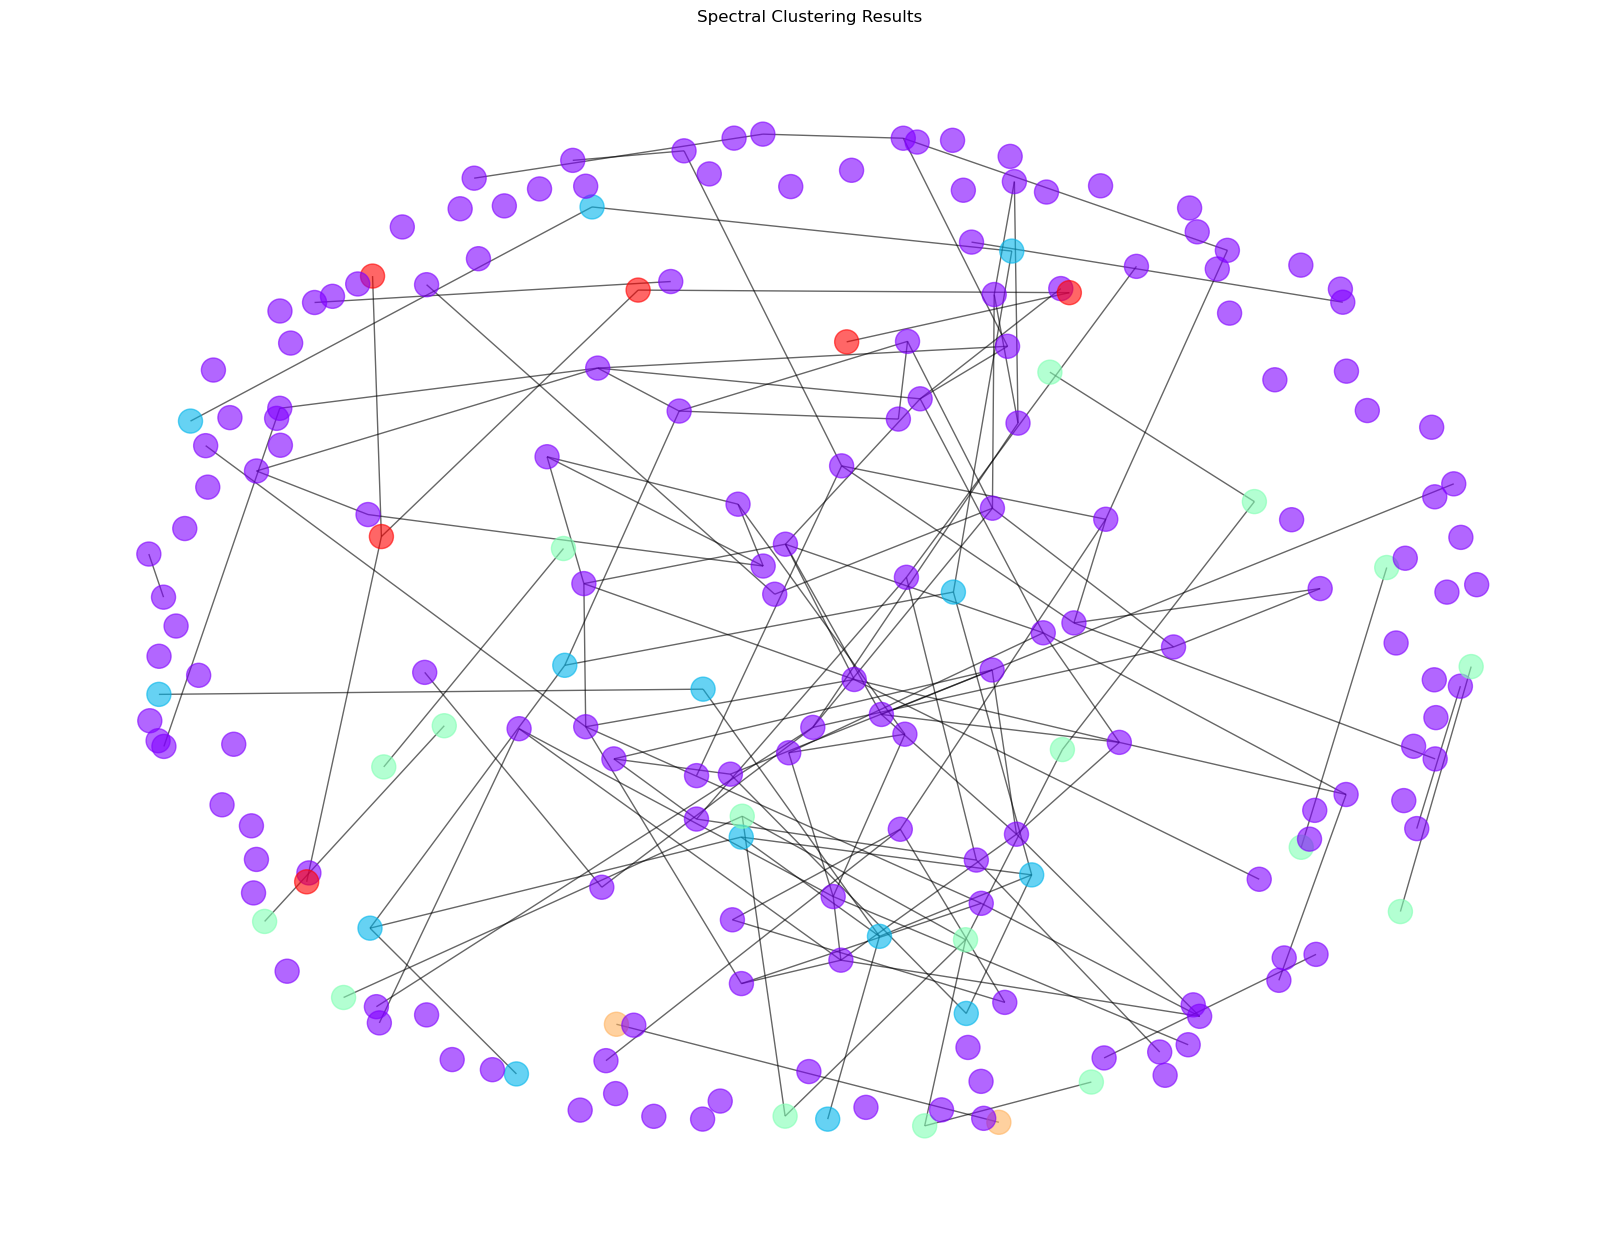

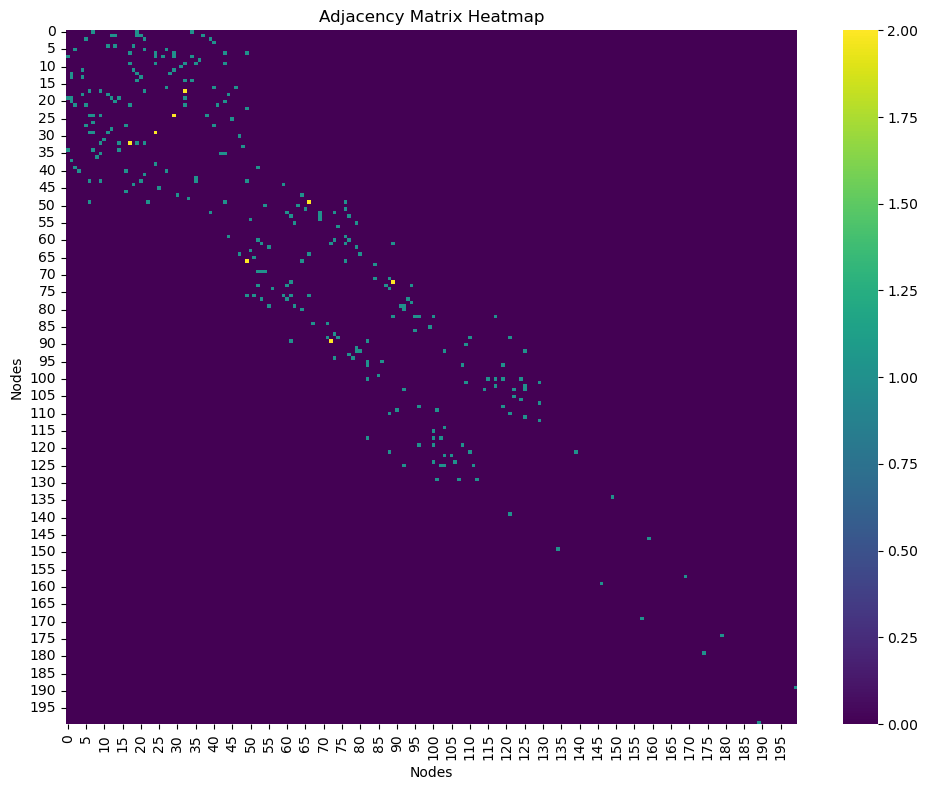

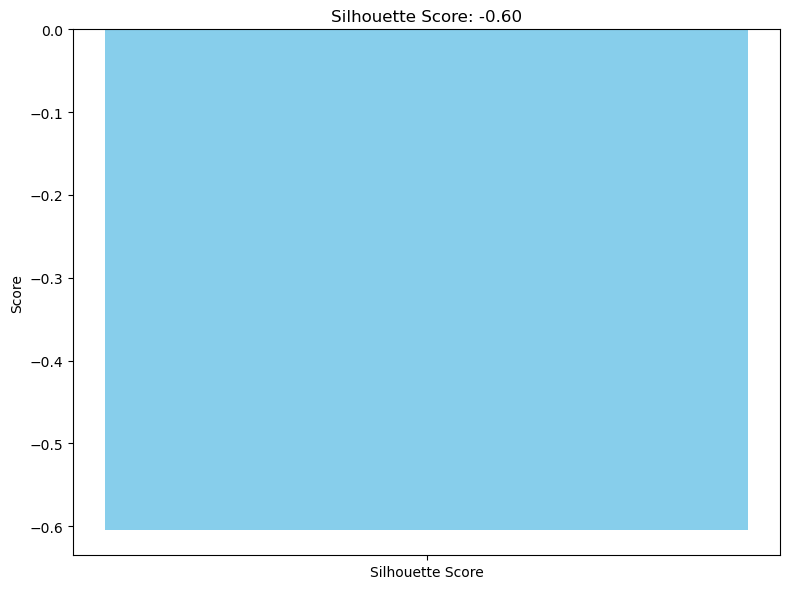

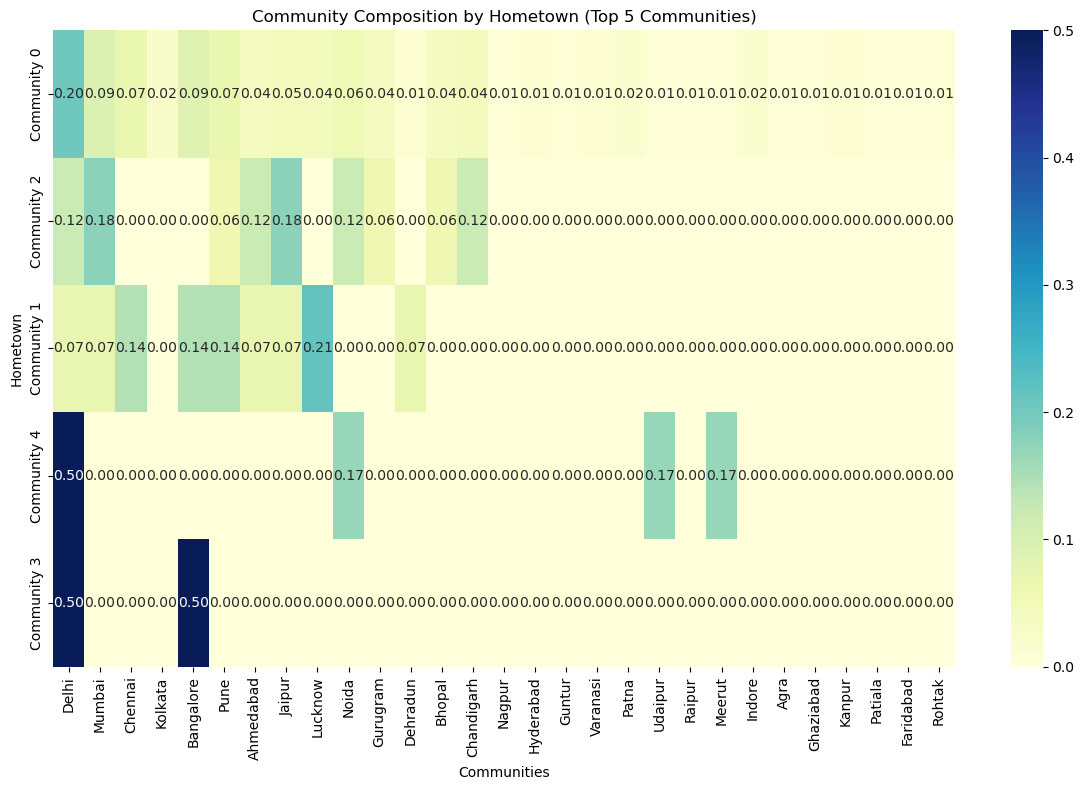

In [1]:
if __name__ == "__main__":
    # Load data
    nodes, layers = load_data()

    # Create graph
    G = create_interlayer_graph(nodes, layers)

    # Perform Spectral Clustering
    num_clusters = 5  # Define the number of clusters
    partition = spectral_clustering(G, num_clusters=num_clusters)

    # Visualize clustering results
    plot_communities(G, partition)

    # Plot adjacency matrix heatmap
    adjacency_heatmap(G)

    # Visualize silhouette score
    plot_silhouette(G, partition)

    # Plot heatmap of community composition
    community_composition_heatmap(partition, nodes, attribute="hometown", top_n=5)